In [4]:
%load_ext autoreload
%autoreload 2

#

import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from filter import raymond_lowpass
from scipy import signal

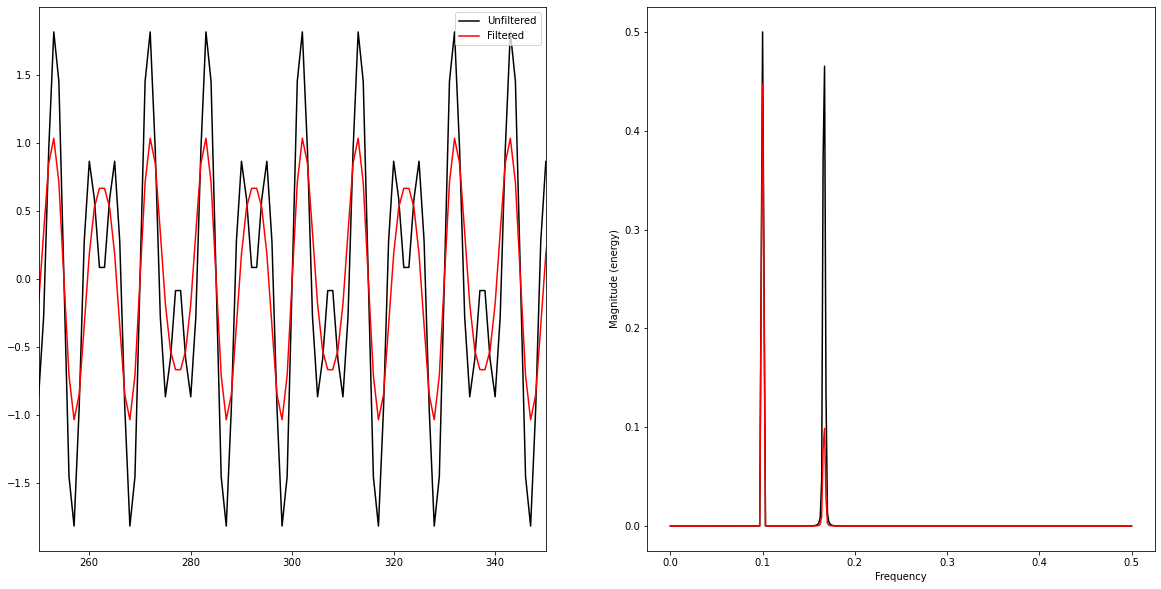

In [5]:
wave1 = [1.0,6.0]
wave2 = [1.0,10.0]
x     = np.arange(640)
eps   = 100.0

field = wave1[0]*np.sin(2.0*np.pi*x/wave1[1]) + wave2[0]*np.sin(2.0*np.pi*x/wave2[1])

ffield = raymond_lowpass.raymond1d_lowpass(field, eps)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axes[0].plot(x, field, color='k', label='Unfiltered')
axes[0].set_xlim(250,350)
axes[0].plot(x, ffield, color='r', label='Filtered')
axes[0].legend(['Unfiltered', 'Filtered'])

line1 = axes[1].magnitude_spectrum(field, Fs=1.0, color='k')
line2 = axes[1].magnitude_spectrum(ffield, Fs=1.0, color='r')


In [61]:
def Raymond_6_Filter1D(XY, EPS, **kwargs):
    """
    Compute solution for 1D column Raymond's 1988 6th order implicit tangent filter.
    
    Adapted from Raymond's original code and from example code on Program Creek.
       
    https://www.programcreek.com/python/example/97027/scipy.linalg.solve_banded [example 3]
    
    See RAYMOND, 1988, MWR, 116, 2132-2141 for details on parameter EPS
    
    Lou Wicker, Oct 2021 
    """
    
    try:
        from scipy.sparse import spdiags
        from scipy.sparse.linalg import spsolve
    except ImportError: 
        raise ImportError("Raymond_6_Filter1D requires scipy.sparse libraries.")
        
    N = len(x)
        
    # Construct RHS (0-based indexing, not 1 like in fortran)
    NM1 = N-1
    NM2 = N-2
    NM3 = N-3
    NM4 = N-4
    NM5 = N-5

    # Initialize the matrix and rhs
    Ab  = np.zeros((7,N), dtype=np.float64)
    RHS = np.zeros((N,), dtype=np.float64)

    # Set boundary values
    Ab[0,0:3] = (0.0,       0.0,                         1.0)
    Ab[1,0:3] = (0.0,       0.0,                 (1.0 + EPS))
    Ab[2,0:3] = (0.0,       1.0,             4.0*(1.0 - EPS))
    Ab[3,0:3] = (1.0,  2.0*(1.0 + EPS),      6.0*(1.0 + EPS))
    
    Ab[4,0:3] = Ab[2,0:3]
    Ab[5,0:3] = Ab[1,0:3]
    Ab[6,0:3] = Ab[0,0:3]
    
    Ab[0,NM3:N] = (        1.0,             0.0,          0.0)
    Ab[1,NM3:N] = (    (1.0 + EPS),         0.0,          0.0)
    Ab[2,NM3:N] = (4.0*(1.0 - EPS),         1.0,          0.0)
    Ab[3,NM3:N] = (6.0*(1.0 + EPS), 2.0*(1.0 + EPS),      1.0)
    
    Ab[4,NM3:N] = Ab[2,NM3:N]
    Ab[5,NM3:N] = Ab[1,NM3:N]
    Ab[6,NM3:N] = Ab[0,NM3:N]

    # compute the internal diagonals
    
    for i in np.arange(3,NM3):

        Ab[0,i] =  1.0 - EPS          # Z
        Ab[1,i] =  6.0 * (1.0 + EPS)  # A
        Ab[2,i] = 15.0 * (1.0 - EPS)  # B
        Ab[3,i] = 20.0 * (1.0 + EPS)  # C
        Ab[4,i] = Ab[2,i]             # D
        Ab[5,i] = Ab[1,i]             # E
        Ab[6,i] = Ab[0,i]             # F
 
    # Convert diagonals to sparse matrix format (the tricky part as far as I am concerned!)
    
    diagonals = [Ab[3,1:-1],Ab[2,1:-1],Ab[4,1:-1],Ab[1,1:-1],Ab[5,1:-1],Ab[0,1:-1],Ab[6,1:-1]]
    A = spdiags(diagonals, [0, -1, 1, -2, 2, -3, 3], N-2, N-2, format='csc')

    # Compute RHS filter
    RHS[  0] = 0.0
    RHS[  1] = EPS*(XY[  0]-2.0*XY[  1]+XY[  2]) 
    RHS[  2] = EPS*(-1.0*(XY[  0]+XY[  4])+4.0*(XY[  1]+XY[  3])-6.0* XY[  2] )
    
    RHS[NM3] = EPS*(-1.0*(XY[NM1]+XY[NM5])+4.0*(XY[NM2]+XY[NM4])-6.0* XY[NM3] )
    RHS[NM2] = EPS*(XY[NM3]-2.0*XY[NM2]+XY[NM1])  
    RHS[NM1] = 0.0 
    
    for J in np.arange(3,NM3):
        RHS[J] = EPS*(       (XY[J-3]+XY[J+3])
               - 6.0*(XY[J-2]+XY[J+2])
               +15.0*(XY[J-1]+XY[J+1])
               -20.0* XY[  J]         )
        
    XRES = spsolve(A, RHS[1:-1])

    XF = XY.copy()

    XF[1:-1] = XF[1:-1] + XRES
    

    return XF

(0.0, 0.75)

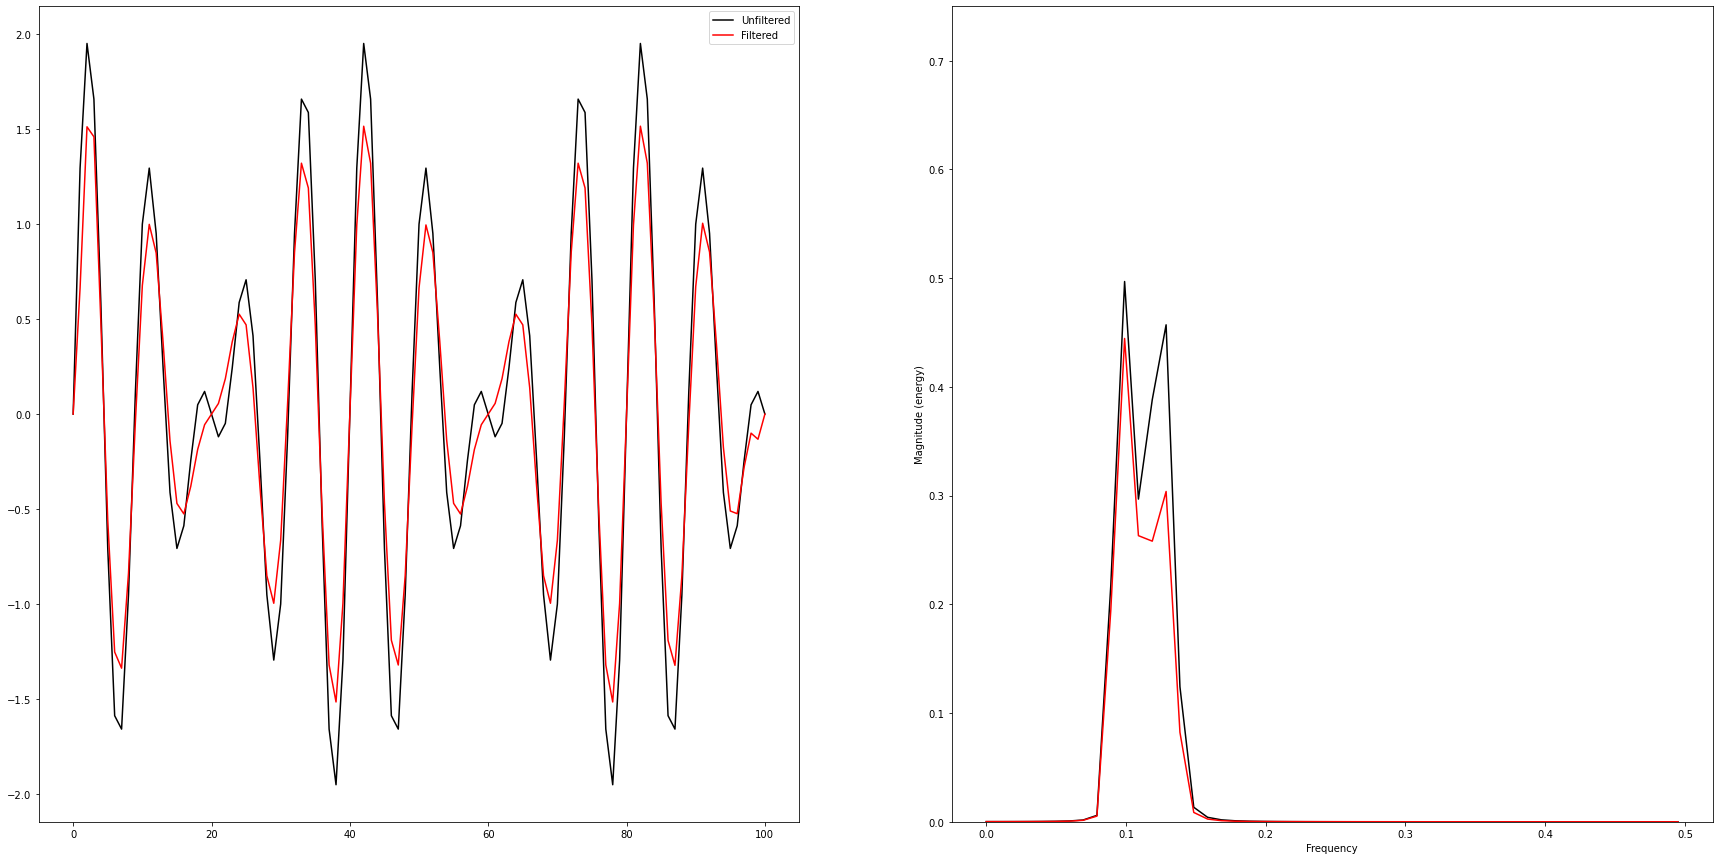

In [71]:
wave1 = [1.0,8.0]
wave2 = [1.0,10.0]
x     = np.arange(101)
eps   = 100.

field = wave1[0]*np.sin(2.0*np.pi*x/wave1[1]) + wave2[0]*np.sin(2.0*np.pi*x/wave2[1])

ffield = Raymond_6_Filter1D(field, eps)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15))

axes[0].plot(x, field, color='k', label='Unfiltered')
#axes[0].set_xlim(250,350)
#axes[0].set_ylim(-2.0,2.0)
axes[0].plot(x, ffield, color='r', label='Filtered')
axes[0].legend(['Unfiltered', 'Filtered'])

line1 = axes[1].magnitude_spectrum(field, Fs=1.0, color='k')
line2 = axes[1].magnitude_spectrum(ffield, Fs=1.0, color='r')
axes[1].set_ylim(.0,0.75)

In [69]:
def Raymond_10_Filter1D(XY, EPS, **kwargs):
    """
    Compute solution for 1D column Raymond's 1988 10th order implicit tangent filter.
    
    Adapted from Raymond's original code and from example code on Program Creek.
       
    https://www.programcreek.com/python/example/97027/scipy.linalg.solve_banded [example 3]
    
    See RAYMOND, 1988, MWR, 116, 2132-2141 for details on parameter EPS
    
    Equation
    
    (1-eps)*(p(i+2)+p(i-2)) + 10*(1+eps)(p(i+4)+p(i-4)) + 45*(1-eps)(p(i+3)+p(i-3)) 
    + 120*(1+eps)(p(i+2)+p(i-2)) + 210*(1-eps)(p(i+1)+p(i-1)) -252*(eps)(p(i))  
    
    =
    
    eps * ((u(i+2)+p(i-2)) - 010*u(i+4)+u(i-4)) + 45*(u(i+3)+u(i-3)) - 120*(u(i+2)+u(i-2))
     + 210*(u(i+2)+u(i-2)) - 252*u(i))
    
    [-252.  210.  210. -120. -120.   45.   45.  -10.  -10.    1.    1.]
    
    Lou Wicker, Oct 2021 
    """
    
    try:
        from scipy.sparse import spdiags
        from scipy.sparse.linalg import spsolve
    except ImportError: 
        raise ImportError("Raymond_10_Filter1D requires scipy.sparse libraries.")
        
    N = len(x)
        
    # Construct RHS (0-based indexing, not 1 like in fortran)
    NM1 = N-1
    NM2 = N-2
    NM3 = N-3
    NM4 = N-4
    NM5 = N-5
    NM6 = N-6
    NM7 = N-7
    NM8 = N-7

    # Initialize the matrix and rhs
    Ab  = np.zeros((11,N), dtype=np.float64)
    RHS = np.zeros((N,),   dtype=np.float64)

    # Set boundary values
    Ab[ 0,0:5] = (0.0,                 0.0,              0.0,              0.0,                  1.0)
    Ab[ 1,0:5] = (0.0,                 0.0,              0.0,              0.0,          (1.0 + EPS))
    Ab[ 2,0:5] = (0.0,                 0.0,              0.0,              1.0,      4.0*(1.0 - EPS))
    Ab[ 3,0:5] = (0.0,                 0.0,              1.0,      2.0*(1.0 + EPS),  6.0*(1.0 + EPS))
    Ab[ 4,0:5] = (0.0,                 1.0,      4.0*(1.0 - EPS), 15.0*(1.0 - EPS), 15.0*(1.0 - EPS))
    Ab[ 5,0:5] = (1.0,         4.0*(1.0 - EPS), 15.0*(1.0 - EPS), 15.0*(1.0 - EPS),              0.0)
    
    Ab[ 6,0:5] = Ab[4,0:5]
    Ab[ 7,0:5] = Ab[3,0:5]
    Ab[ 8,0:5] = Ab[2,0:5] 
    Ab[ 9,0:5] = Ab[1,0:5]
    Ab[10,0:5] = Ab[0,0:5]
    
    Ab[ 0,NM5:N] = (         1.0,              0.0,             0.0,            0.0,                 0.0)
    Ab[ 1,NM5:N] = (     (1.0 + EPS),          0.0,             0.0,            0.0,                 0.0)
    Ab[ 2,NM5:N] = ( 4.0*(1.0 - EPS),          1.0,             0.0,            0.0,                 0.0)
    Ab[ 3,NM5:N] = ( 6.0*(1.0 + EPS),  2.0*(1.0 + EPS),         1.0,            0.0,                 0.0)
    Ab[ 4,NM5:N] = (15.0*(1.0 - EPS), 15.0*(1.0 - EPS),  4.0*(1.0 - EPS),       1.0,                 0.0)
    Ab[ 5,NM5:N] = (         0.0,     15.0*(1.0 - EPS), 15.0*(1.0 - EPS), 4.0*(1.0 - EPS),           1.0)
   
    Ab[ 6,NM5:N] = Ab[4,NM5:N]
    Ab[ 7,NM5:N] = Ab[3,NM5:N]
    Ab[ 8,NM5:N] = Ab[2,NM5:N]
    Ab[ 9,NM5:N] = Ab[1,NM5:N]
    Ab[10,NM5:N] = Ab[0,NM5:N]

    # compute the internal diagonals
    
    for i in np.arange(5,NM5):

        Ab[ 0,i] =         (1.0 - EPS)  # Z
        Ab[ 1,i] =  10.0 * (1.0 + EPS)  # A
        Ab[ 2,i] =  45.0 * (1.0 - EPS)  # B
        Ab[ 3,i] = 120.0 * (1.0 + EPS)  # C
        Ab[ 4,i] = 210.0 * (1.0 - EPS)  # C
        Ab[ 5,i] = 252.0 * (1.0 + EPS)  # C
        Ab[ 6,i] = Ab[4,i]              # D
        Ab[ 7,i] = Ab[3,i]              # E
        Ab[ 8,i] = Ab[2,i]              # F
        Ab[ 9,i] = Ab[1,i]              # F
        Ab[10,i] = Ab[0,i]              # F
 
    # Convert diagonals to sparse matrix format (the tricky part as far as I am concerned!)
    
    diagonals = [Ab[5,1:-1],Ab[4,1:-1],Ab[6,1:-1],Ab[3,1:-1],Ab[7,1:-1],
                 Ab[2,1:-1],Ab[8,1:-1],Ab[1,1:-1],Ab[9,1:-1],Ab[0,1:-1],Ab[10,1:-1]]
    
    A = spdiags(diagonals, [0, -1, 1, -2, 2, -3, 3, -4, 4, -5, 5], N-2, N-2, format='csc')

    # Compute RHS filter
    RHS[  0] = 0.0
    RHS[  1] = EPS*(XY[  0]-2.0*XY[  1]+XY[  2]) 
    RHS[  2] = EPS*(-1.0*(XY[  0]+XY[  4])+4.0*(XY[  1]+XY[  3])-6.0* XY[  2])
    
    RHS[  3] = EPS*((XY[  0]+XY[  6]) -6.0*(XY[  1]+XY[  5]) + 15.0*(XY[  2]+XY[  4]) -20.*XY[  3])
    
    RHS[  4] = EPS*((XY[  1]+XY[  7]) -6.0*(XY[  2]+XY[  6]) + 15.0*(XY[  3]+XY[  5]) -20.*XY[4])
    
    RHS[NM5] = EPS*((XY[NM8]+XY[NM2]) - 6.0*(XY[NM7]+XY[NM3]) + 15.0*(XY[NM6]+XY[NM4]) - 20.*XY[NM5])
                    
    RHS[NM4] = EPS*( (XY[NM7]+XY[NM1]) - 6.0*(XY[NM6]+XY[NM2]) + 15.0*(XY[NM5]+XY[NM3]) - 20.*XY[NM4])
                    
    RHS[NM3] = EPS*(-1.0*(XY[NM1]+XY[NM5])+4.0*(XY[NM2]+XY[NM4])-6.0* XY[NM3] )
    RHS[NM2] = EPS*(XY[NM3]-2.0*XY[NM2]+XY[NM1])  
    RHS[NM1] = 0.0 
    
    for J in np.arange(5,NM5):
        RHS[J] = EPS*((XY[J-5]+XY[J+5])
               - 10.0*(XY[J-4]+XY[J+4])
               + 45.0*(XY[J-3]+XY[J+3])
               -120.0*(XY[J-2]+XY[J+2])
               +210.0*(XY[J-1]+XY[J+1])
               -252.0* XY[  J]         )
        
    XRES = spsolve(A, RHS[1:-1])

    XF = XY.copy()

    XF[1:-1] = XF[1:-1] + XRES
    

    return XF

(0.0, 0.75)

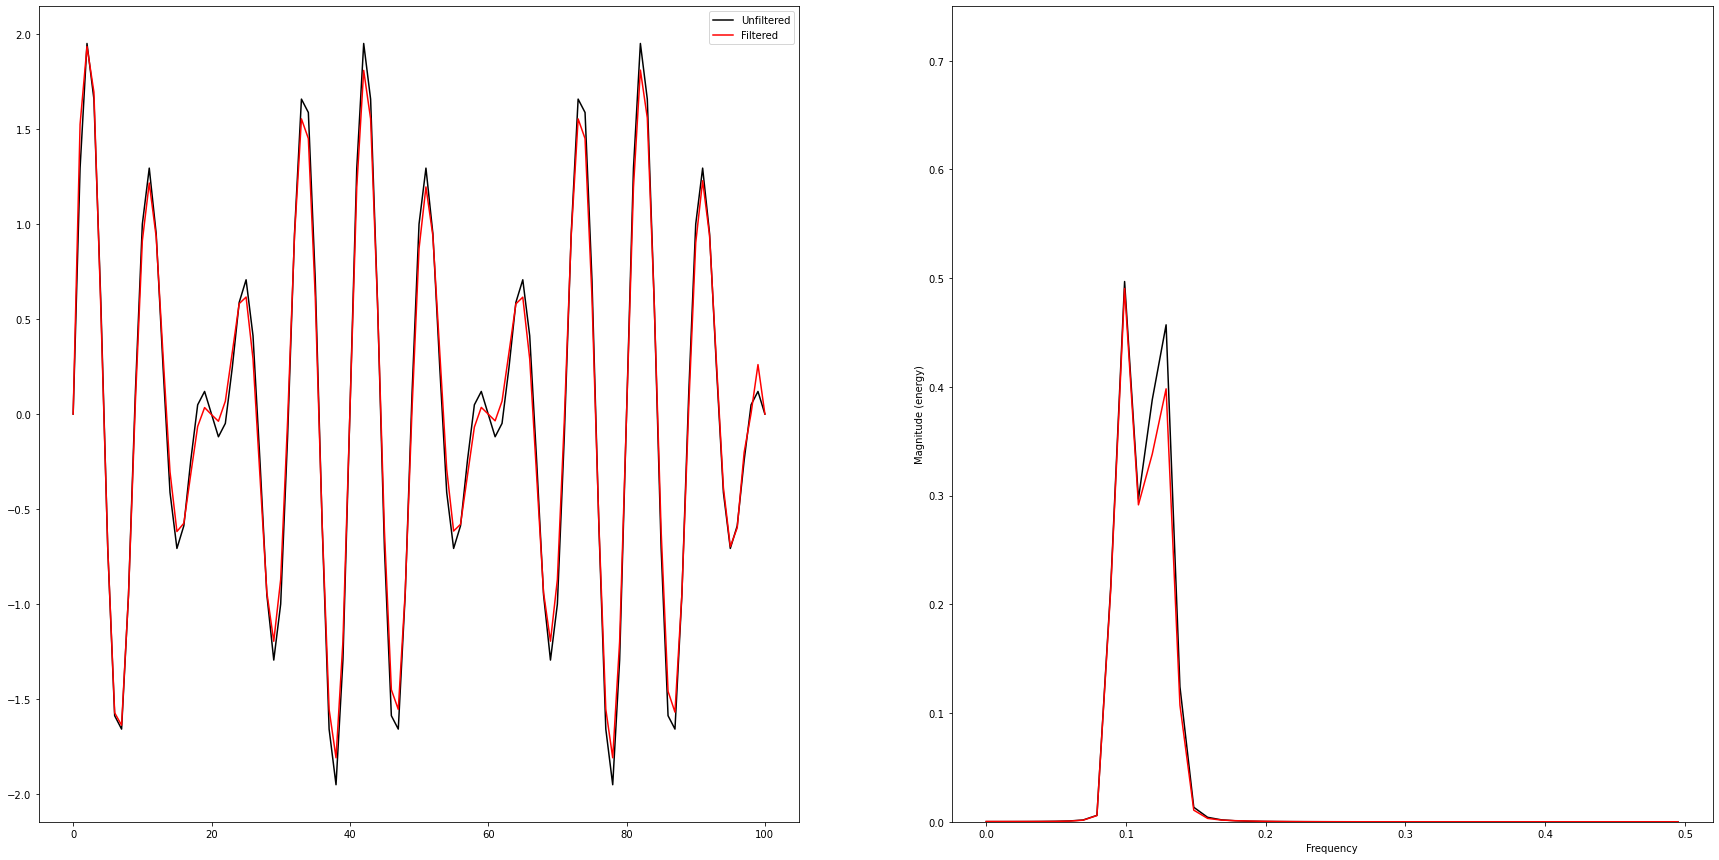

In [72]:
wave1 = [1.0,8.0]
wave2 = [1.0,10.0]
x     = np.arange(101)
eps   = 1000.

field = wave1[0]*np.sin(2.0*np.pi*x/wave1[1]) + wave2[0]*np.sin(2.0*np.pi*x/wave2[1])

ffield = Raymond_10_Filter1D(field, eps)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15))

axes[0].plot(x, field, color='k', label='Unfiltered')
#axes[0].set_xlim(250,350)
#axes[0].set_ylim(-2.0,2.0)
axes[0].plot(x, ffield, color='r', label='Filtered')
axes[0].legend(['Unfiltered', 'Filtered'])

line1 = axes[1].magnitude_spectrum(field, Fs=1.0, color='k')
line2 = axes[1].magnitude_spectrum(ffield, Fs=1.0, color='r')
axes[1].set_ylim(.0,0.75)